Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

Functions

In [3]:
def calc_statistics(X, y):
    data = X.copy()
    data['target'] = y

    cols = data.columns.tolist()
    cols.pop(4)

    # AVG
    avg_df = pd.pivot_table(data, values=data.columns.tolist(), index=['target'], aggfunc={'sepal length (cm)': np.average, 'sepal width (cm)': np.average, 'petal length (cm)': np.average, 'petal width (cm)': np.average}, fill_value=0).reset_index()
    avg_df = pd.melt(avg_df, id_vars=['target'], value_vars=cols, var_name='feature', value_name='avg')

    # MAX
    max_df = pd.pivot_table(data, values=data.columns.tolist(), index=['target'], aggfunc={'sepal length (cm)': np.max, 'sepal width (cm)': np.max, 'petal length (cm)': np.max, 'petal width (cm)': np.max}, fill_value=0).reset_index()
    max_df = pd.melt(max_df, id_vars=['target'], value_vars=cols, var_name='feature', value_name='max')

    # MIN
    min_df = pd.pivot_table(data, values=data.columns.tolist(), index=['target'], aggfunc={'sepal length (cm)': np.min, 'sepal width (cm)': np.min, 'petal length (cm)': np.min, 'petal width (cm)': np.min}, fill_value=0).reset_index()
    min_df = pd.melt(min_df, id_vars=['target'], value_vars=cols, var_name='feature', value_name='min')

    # STD
    std_df = pd.pivot_table(data, values=data.columns.tolist(), index=['target'], aggfunc={'sepal length (cm)': np.std, 'sepal width (cm)': np.std, 'petal length (cm)': np.std, 'petal width (cm)': np.std}, fill_value=0).reset_index()
    std_df = pd.melt(std_df, id_vars=['target'], value_vars=cols, var_name='feature', value_name='std')

    df = avg_df.set_index(['target', 'feature']).join(max_df.set_index(['target', 'feature'])).join(min_df.set_index(['target', 'feature'])).join(std_df.set_index(['target', 'feature']))
    df = df.reset_index()
    return df


def model_evaluation(y_true, y_pred, beta=1, mode='in depth'):
    p_0, r_0, f_0, s_0 = precision_recall_fscore_support(y_true, y_pred, beta=beta, average='weighted')
    a_0 = accuracy_score(y_true, y_pred)
    print('Overall Accuracy: {:.1%}'.format(a_0))
    print('Overall F{b:.0f}-score: {f:.1%}'.format(b=beta, f=f_0))
    # print('Overall Precision: {:.1%}'.format(p_0))
    # print('Overall Recall: {:.1%}'.format(r_0))
    if mode == 'in depth':
        precision_per_class = precision_score(y_true, y_pred, average=None)
        p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average=None)
        for i in range(len(precision_per_class)):
            print('------- Class {n} (obs.: {obs}) -------'.format(n=i, obs=s[i]))
            print('F{b:.0f}-score: {f:.1%}'.format(b=beta, f=f[i]))
            print('Precision: {:.1%}'.format(p[i]))
            print('Recall: {:.1%}'.format(r[i]))

        cm = confusion_matrix(y_true, y_pred)
        total_obs = cm.sum(axis=1).sum()
        tp = cm.diagonal().sum()
        over_acc = 1 - (total_obs - tp) / total_obs
        print('------- Confusion matrix -------')
        print(cm)

    return a_0, f_0


def sample_mistakes(X, y_true, y_pred):
    comp_df = X.copy()
    comp_df['y_true'] = y_true
    comp_df['y_pred'] = y_pred
    return comp_df[comp_df['y_true'] != comp_df['y_pred']]


Load data

In [4]:
data, target = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
X = data.copy()
y = target
data["target"] = target

### Data exploration

In [5]:
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


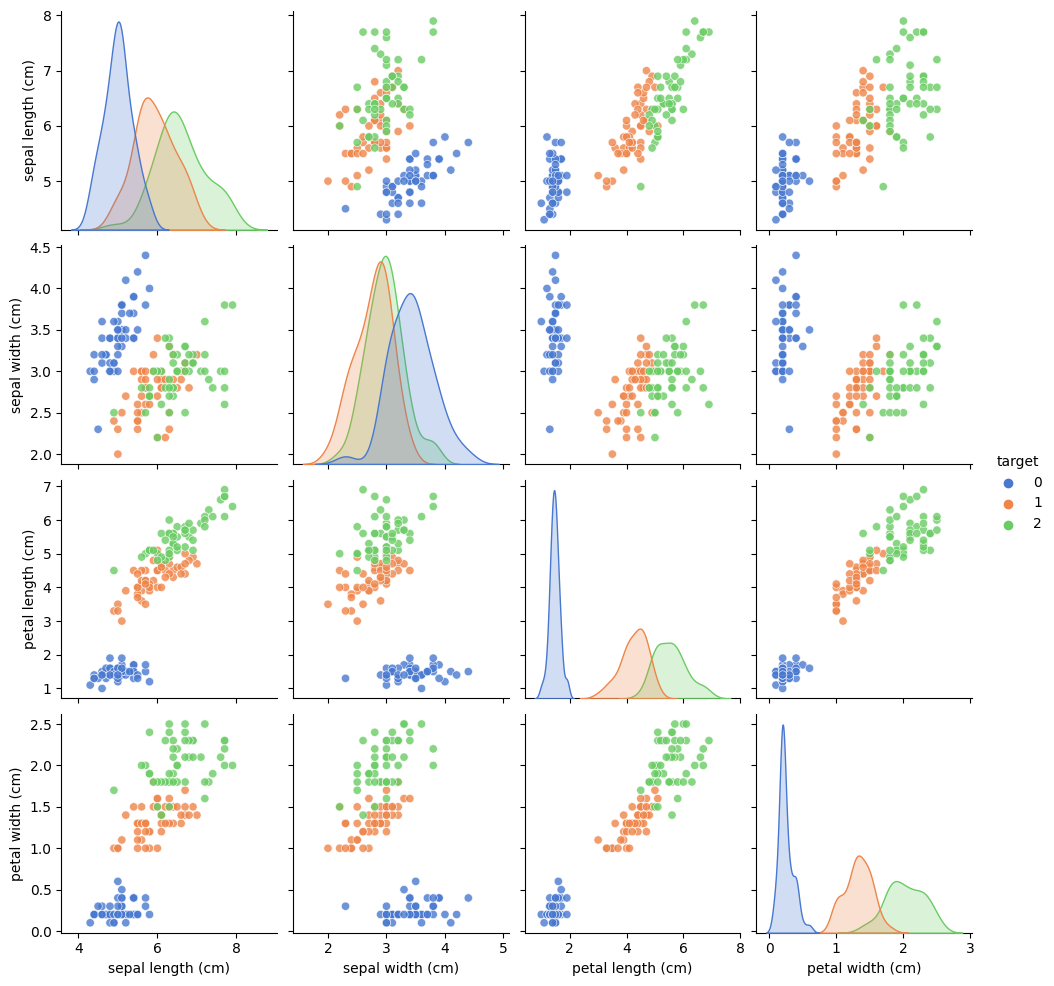

In [6]:
sns.pairplot(data, kind="scatter", diag_kind="kde", hue="target",
             palette="muted", plot_kws={'alpha':0.8})
plt.show()

Train & test sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

Model functions

In [8]:
stat = calc_statistics(X_train, y_train)

def cutoff_model(x, t1=2, t2=0.5):
    if x < t1:
        return 0
    if x > t2:
        return 2
    return 1

def logistic_regression(X, y):
    lr = LogisticRegression().fit(X, y)
    return lr

def predict(X, model, params={}):
    if model == 'cutoff':
        avg = stat[(stat['target']==2)&(stat['feature']=='petal length (cm)')]['avg'].item()
        std = stat[(stat['target']==2)&(stat['feature']=='petal length (cm)')]['std'].item()        
        return X['petal length (cm)'].apply(lambda x: cutoff_model(x, 2, avg-std)).rename('y_pred')
    if model == 'cutoff var':
        return X['petal length (cm)'].apply(lambda x: cutoff_model(x, 2, params['t2'])).rename('y_pred')
    if model == 'logistic':
        return pd.Series(params['model'].predict(X))

### 1) Cut-off

### Model Evaluation

#### Manual cut-off

In [9]:
y_pred = predict(X_train, 'cutoff')
model_evaluation(y_train, y_pred, mode='in depth')

Overall Accuracy: 94.0%
Overall F1-score: 94.0%
------- Class 0 (obs.: 32) -------
F1-score: 100.0%
Precision: 100.0%
Recall: 100.0%
------- Class 1 (obs.: 33) -------
F1-score: 91.7%
Precision: 84.6%
Recall: 100.0%
------- Class 2 (obs.: 35) -------
F1-score: 90.6%
Precision: 100.0%
Recall: 82.9%
------- Confusion matrix -------
[[32  0  0]
 [ 0 33  0]
 [ 0  6 29]]


(0.94, 0.9396875)

In [10]:
y_pred = predict(X_test, 'cutoff')
model_evaluation(y_test, y_pred, mode='in depth')

Overall Accuracy: 92.0%
Overall F1-score: 91.9%
------- Class 0 (obs.: 18) -------
F1-score: 100.0%
Precision: 100.0%
Recall: 100.0%
------- Class 1 (obs.: 17) -------
F1-score: 88.9%
Precision: 84.2%
Recall: 94.1%
------- Class 2 (obs.: 15) -------
F1-score: 85.7%
Precision: 92.3%
Recall: 80.0%
------- Confusion matrix -------
[[18  0  0]
 [ 0 16  1]
 [ 0  3 12]]


(0.92, 0.9193650793650794)

In [11]:
sample_mistakes(X_test, y_test, y_pred)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y_true,y_pred
113,5.7,2.5,5.0,2.0,2,1
126,6.2,2.8,4.8,1.8,2,1
127,6.1,3.0,4.9,1.8,2,1
83,6.0,2.7,5.1,1.6,1,2


#### Variable cut-off

In [12]:
for i in range(44, 53, 1):
    print('------------- {cutoff} -------------'.format(cutoff=i/10))
    y_pred = predict(X_train, 'cutoff var', {"t2": i/10})
    model_evaluation(y_train, y_pred, mode='simplified')

------------- 4.4 -------------
Overall Accuracy: 88.0%
Overall F1-score: 87.5%
------------- 4.5 -------------
Overall Accuracy: 91.0%
Overall F1-score: 90.9%
------------- 4.6 -------------
Overall Accuracy: 93.0%
Overall F1-score: 92.9%
------------- 4.7 -------------
Overall Accuracy: 97.0%
Overall F1-score: 97.0%
------------- 4.8 -------------
Overall Accuracy: 97.0%
Overall F1-score: 97.0%
------------- 4.9 -------------
Overall Accuracy: 96.0%
Overall F1-score: 96.0%
------------- 5.0 -------------
Overall Accuracy: 94.0%
Overall F1-score: 94.0%
------------- 5.1 -------------
Overall Accuracy: 89.0%
Overall F1-score: 88.8%
------------- 5.2 -------------
Overall Accuracy: 87.0%
Overall F1-score: 86.6%


In [13]:
y_pred = predict(X_test, 'cutoff var', {"t2": 4.7})
model_evaluation(y_test, y_pred, mode='in depth')

Overall Accuracy: 92.0%
Overall F1-score: 91.9%
------- Class 0 (obs.: 18) -------
F1-score: 100.0%
Precision: 100.0%
Recall: 100.0%
------- Class 1 (obs.: 17) -------
F1-score: 86.7%
Precision: 100.0%
Recall: 76.5%
------- Class 2 (obs.: 15) -------
F1-score: 88.2%
Precision: 78.9%
Recall: 100.0%
------- Confusion matrix -------
[[18  0  0]
 [ 0 13  4]
 [ 0  0 15]]


(0.92, 0.9193725490196079)

### 2) Logistic Regression

In [14]:
lr = logistic_regression(X_train, y_train)
y_pred = predict(X_train, 'logistic', {'model': lr})
model_evaluation(y_train, y_pred, mode='in depth')

Overall Accuracy: 98.0%
Overall F1-score: 98.0%
------- Class 0 (obs.: 32) -------
F1-score: 100.0%
Precision: 100.0%
Recall: 100.0%
------- Class 1 (obs.: 33) -------
F1-score: 97.0%
Precision: 97.0%
Recall: 97.0%
------- Class 2 (obs.: 35) -------
F1-score: 97.1%
Precision: 97.1%
Recall: 97.1%
------- Confusion matrix -------
[[32  0  0]
 [ 0 32  1]
 [ 0  1 34]]


c:\Users\pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.98, 0.98)

In [16]:
y_pred = predict(X_test, 'logistic', {'model': lr})
model_evaluation(y_test, y_pred, mode='in depth')

Overall Accuracy: 96.0%
Overall F1-score: 96.0%
------- Class 0 (obs.: 18) -------
F1-score: 100.0%
Precision: 100.0%
Recall: 100.0%
------- Class 1 (obs.: 17) -------
F1-score: 93.8%
Precision: 100.0%
Recall: 88.2%
------- Class 2 (obs.: 15) -------
F1-score: 93.8%
Precision: 88.2%
Recall: 100.0%
------- Confusion matrix -------
[[18  0  0]
 [ 0 15  2]
 [ 0  0 15]]


(0.96, 0.96)

### 3) Logistic Regression